# Accessing the Coadd data using the Data Butler
<br>Owner: **Jim Chiang** ([@jchiang87](https://github.com/LSSTDESC/DC2-analysis/issues/new?body=@jchiang87))
<br>Last Verified to Run: **2018-10-26** (by @yymao)

This notebook shows how to read in the coadd catalog data for an entire tract using the LSST Data Management (DM) data butler, and construct a Pandas dataframe with the columns needed to apply the weak lensing cuts used in recent analysis of data from Hyper Suprime Cam [Mandelbaum et al (2018)](https://arxiv.org/abs/1705.06745) using cuts given by [Francois in Slack](https://lsstc.slack.com/archives/C77DDKZHR/p1525197444000687).

We have a [notebook that performs a similar analysis using GCR](https://github.com/LSSTDESC/DC2-analysis/blob/master/Notebooks/DC2%20Coadd%20Run1.1p%20GCR%20access%20--%20HSC%20selection.ipynb).  See also [the more general script](https://github.com/LSSTDESC/DC2-analysis/blob/master/scripts/merge_tract_cat.py) for extracting the coadd data from a tract into an hdf5 file.

### Learning Objectives
After completing and studying this Notebook, you should be able to
1. Read in the coadd catalog data using the DM Butler
2. Construct a Pandas data frame
3. Apply the HSC weak lensing cuts to a catalog of DM-processed data.

## Set Up

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import lsst.daf.persistence as dp

from desc_dc2_dm_data import REPOS

## How To Read DM Science Pipelines Coadd Catalogs into a Pandas Dataframe

Here's a function to do this: pass it a butler and some information about what you want, and get a pandas df object back. In this example, we'll get the forced photometry as well as the model measurements - these are stored in different tables.

In [2]:
def read_tract(butler, tract, filter_='i', num_patches=None):
    """
    Read in the coadd catalog data from the specified tract, looping over patches and concatenating
    into a pandas data frame.  
    
    Notes
    -----
    The `merged` coadd catalog is supplemented with the CModel fluxes from the `forced_src` 
    catalog for the desired filter.

    Parameters
    ----------
    butler: lsst.daf.persistence.Butler
        Data butler that points to the data repository of interest, e.g., the output repository
        for the Run1.1p data.
    tract: lsst.skymap.tractInfo.TractInfo
        The object containing the tract information as obtained from a skyMap object, e.g., via 
        `tract = skymap[tractId]` where `tractId` is the tract number.
    filter_: str ['i']
        Filter to use for extracting the `forced_src` fluxes.
    num_patches: int [None]
        Number of patches to consider.  If None, then use all of the available patches in the tract.

    Returns
    -------
    pandas.DataFrame: This will contain the merged coadd data with the band-specific columns.
    """
    if num_patches is None:
        num_patches = len(tract)
    
    df_list = []
    i = 0
    print("Loop  Patch  Nobj")
    print("=================")
    for patch in tract:
        patchId = '%d,%d' % patch.getIndex()
        dataId = dict(filter=filter_, tract=tract.getId(), patch=patchId)

        # Patches for which there is no data will raise a `NoResults` exception when requested
        # from the butler.  We catch those exceptions, note the missing data, and 
        # continue looping over the patches.
        try:
            forced = butler.get('deepCoadd_forced_src', dataId)
            calib = butler.get('deepCoadd_calexp_calib', dataId)
            calib.setThrowOnNegativeFlux(False)
            merged = butler.get('deepCoadd_ref', dataId)
        except dp.NoResults as eobj:
            print(eobj)
            continue

        # Convert the merged coadd catalog into a pandas DataFrame and add the band-specific
        # quantities from the forced_src coadd catalog as new columns.
        data = merged.asAstropy().to_pandas()
        data[filter_ + '_modelfit_CModel_instFlux'] = forced['modelfit_CModel_instFlux']
        data[filter_ + '_modelfit_CModel_instFluxErr'] = forced['modelfit_CModel_instFluxErr']

        # The calib object applies the zero point to get calibrated magnitudes.
        data[filter_ + '_mag_CModel'] = calib.getMagnitude(forced['modelfit_CModel_instFlux'])
        data[filter_ + '_mag_err_CModel'] = calib.getMagnitude(forced['modelfit_CModel_instFluxErr'])
        data[filter_ + '_modelfit_CModel_SNR'] \
            = forced['modelfit_CModel_instFlux']/forced['modelfit_CModel_instFluxErr']
        data['ext_shapeHSM_HsmShapeRegauss_abs_e'] \
            = np.hypot(data['ext_shapeHSM_HsmShapeRegauss_e1'],
                       data['ext_shapeHSM_HsmShapeRegauss_e2'])
        df_list.append(data)

        # Print the current patch and number of objects added to the final DataFrame.
        print("   {}  {}   {}".format(i, patchId, len(data)))
        i += 1
        if i == num_patches:
            break
    return pd.concat(df_list)

## Accessing the DM Science Pipeline processed data

In order to access the DM Science Pipeline Processed outputs, including images and catalog data, we summon a data butler and provide the path to the data repository where the DM Science Pipeline tasks have written their outputs.

In [3]:
butler = dp.Butler(REPOS['1.2i'])

The `skyMap` object stores the information defining how we decided to divide up the sky into tracts and patches when we did the coaddition.  Here we pick a tract that is near the center of the protoDC2 simulation region.

In [4]:
skymap = butler.get('deepCoadd_skyMap')
tractId = 4851
filter_ = 'i'
num_patches = None
data = read_tract(butler, skymap[tractId], filter_=filter_, num_patches=num_patches)
print("Number of objects in the coadd catalog:", len(data))

Loop  Patch  Nobj
   0  0,0   3198
   1  1,0   5391
   2  2,0   5661
   3  3,0   5705
   4  4,0   4982
   5  5,0   5883
   6  6,0   4743
   7  0,1   3987
   8  1,1   5722
   9  2,1   5616
   10  3,1   5098
   11  4,1   5289
   12  5,1   4735
   13  6,1   5216
   14  0,2   3149
   15  1,2   5754
   16  2,2   5236
   17  3,2   6042
   18  4,2   5138
   19  5,2   5751
   20  6,2   4748
   21  0,3   2910
   22  1,3   6241
   23  2,3   6176
   24  3,3   5832
   25  4,3   5301
   26  5,3   5484
   27  6,3   4675
   28  0,4   3777
   29  1,4   6581
   30  2,4   6376
   31  3,4   5951
   32  4,4   6239
   33  5,4   6254
   34  6,4   5508
   35  0,5   3855
   36  1,5   6316
   37  2,5   6953
   38  3,5   6004
   39  4,5   5902
   40  5,5   6279
   41  6,5   5505
   42  0,6   2745
   43  1,6   4891
   44  2,6   6016
   45  3,6   5851
   46  4,6   6383
   47  5,6   6938
   48  6,6   5361


/opt/lsst/software/stack/python/miniconda3-4.5.4/envs/lsst-scipipe-fcd27eb/lib/python3.6/site-packages/ipykernel/__main__.py:72: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Number of objects in the coadd catalog: 263348


## Making the Selection

First off, we need to apply a baseline set of cuts to remove nan's.

In [5]:
base_mask = ~(np.isnan(data['i_modelfit_CModel_instFlux'])
         | np.isnan(data['ext_shapeHSM_HsmShapeRegauss_resolution'])
         | np.isnan(data['ext_shapeHSM_HsmShapeRegauss_e1']))
data = data[base_mask]
print("Number of objects after baseline cuts:", len(data))

Number of objects after baseline cuts: 137296


Now we get to the weak lensing cuts.   The `detect_isPrimary` flag identifies the primary object in the overlap regions between patches, i.e., applying it resolves duplicates from the different analyses of overlapping patches.

In [6]:
mask = data['detect_isPrimary']
mask &= data['deblend_skipped'] == False
mask &= data['base_PixelFlags_flag_edge'] == False
mask &= data['base_PixelFlags_flag_interpolatedCenter'] == False
mask &= data['base_PixelFlags_flag_saturatedCenter'] == False
mask &= data['base_PixelFlags_flag_crCenter'] == False
mask &= data['base_PixelFlags_flag_bad'] == False
mask &= data['base_PixelFlags_flag_suspectCenter'] == False
mask &= data['base_PixelFlags_flag_clipped'] == False
mask &= data['ext_shapeHSM_HsmShapeRegauss_flag'] == False

# Cut on measured object properties
mask &= data['i_modelfit_CModel_SNR'] >= 10
mask &= data['ext_shapeHSM_HsmShapeRegauss_resolution'] >= 0.3
mask &= data['ext_shapeHSM_HsmShapeRegauss_abs_e'] < 2
mask &= data['ext_shapeHSM_HsmShapeRegauss_sigma'] <= 0.4
mask &= data['i_mag_CModel'] < 24.5 # !!! Doesnt have exinction correction
mask &= data['base_Blendedness_abs_instFlux'] < 10**(-0.375)

Let's make some plots of galaxy properties with the above cuts applied. The figure to compare with is Fig. 22 of [Mandelbaum et al (2018)](https://arxiv.org/abs/1705.06745).

/opt/lsst/software/stack/python/miniconda3-4.5.4/envs/lsst-scipipe-fcd27eb/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


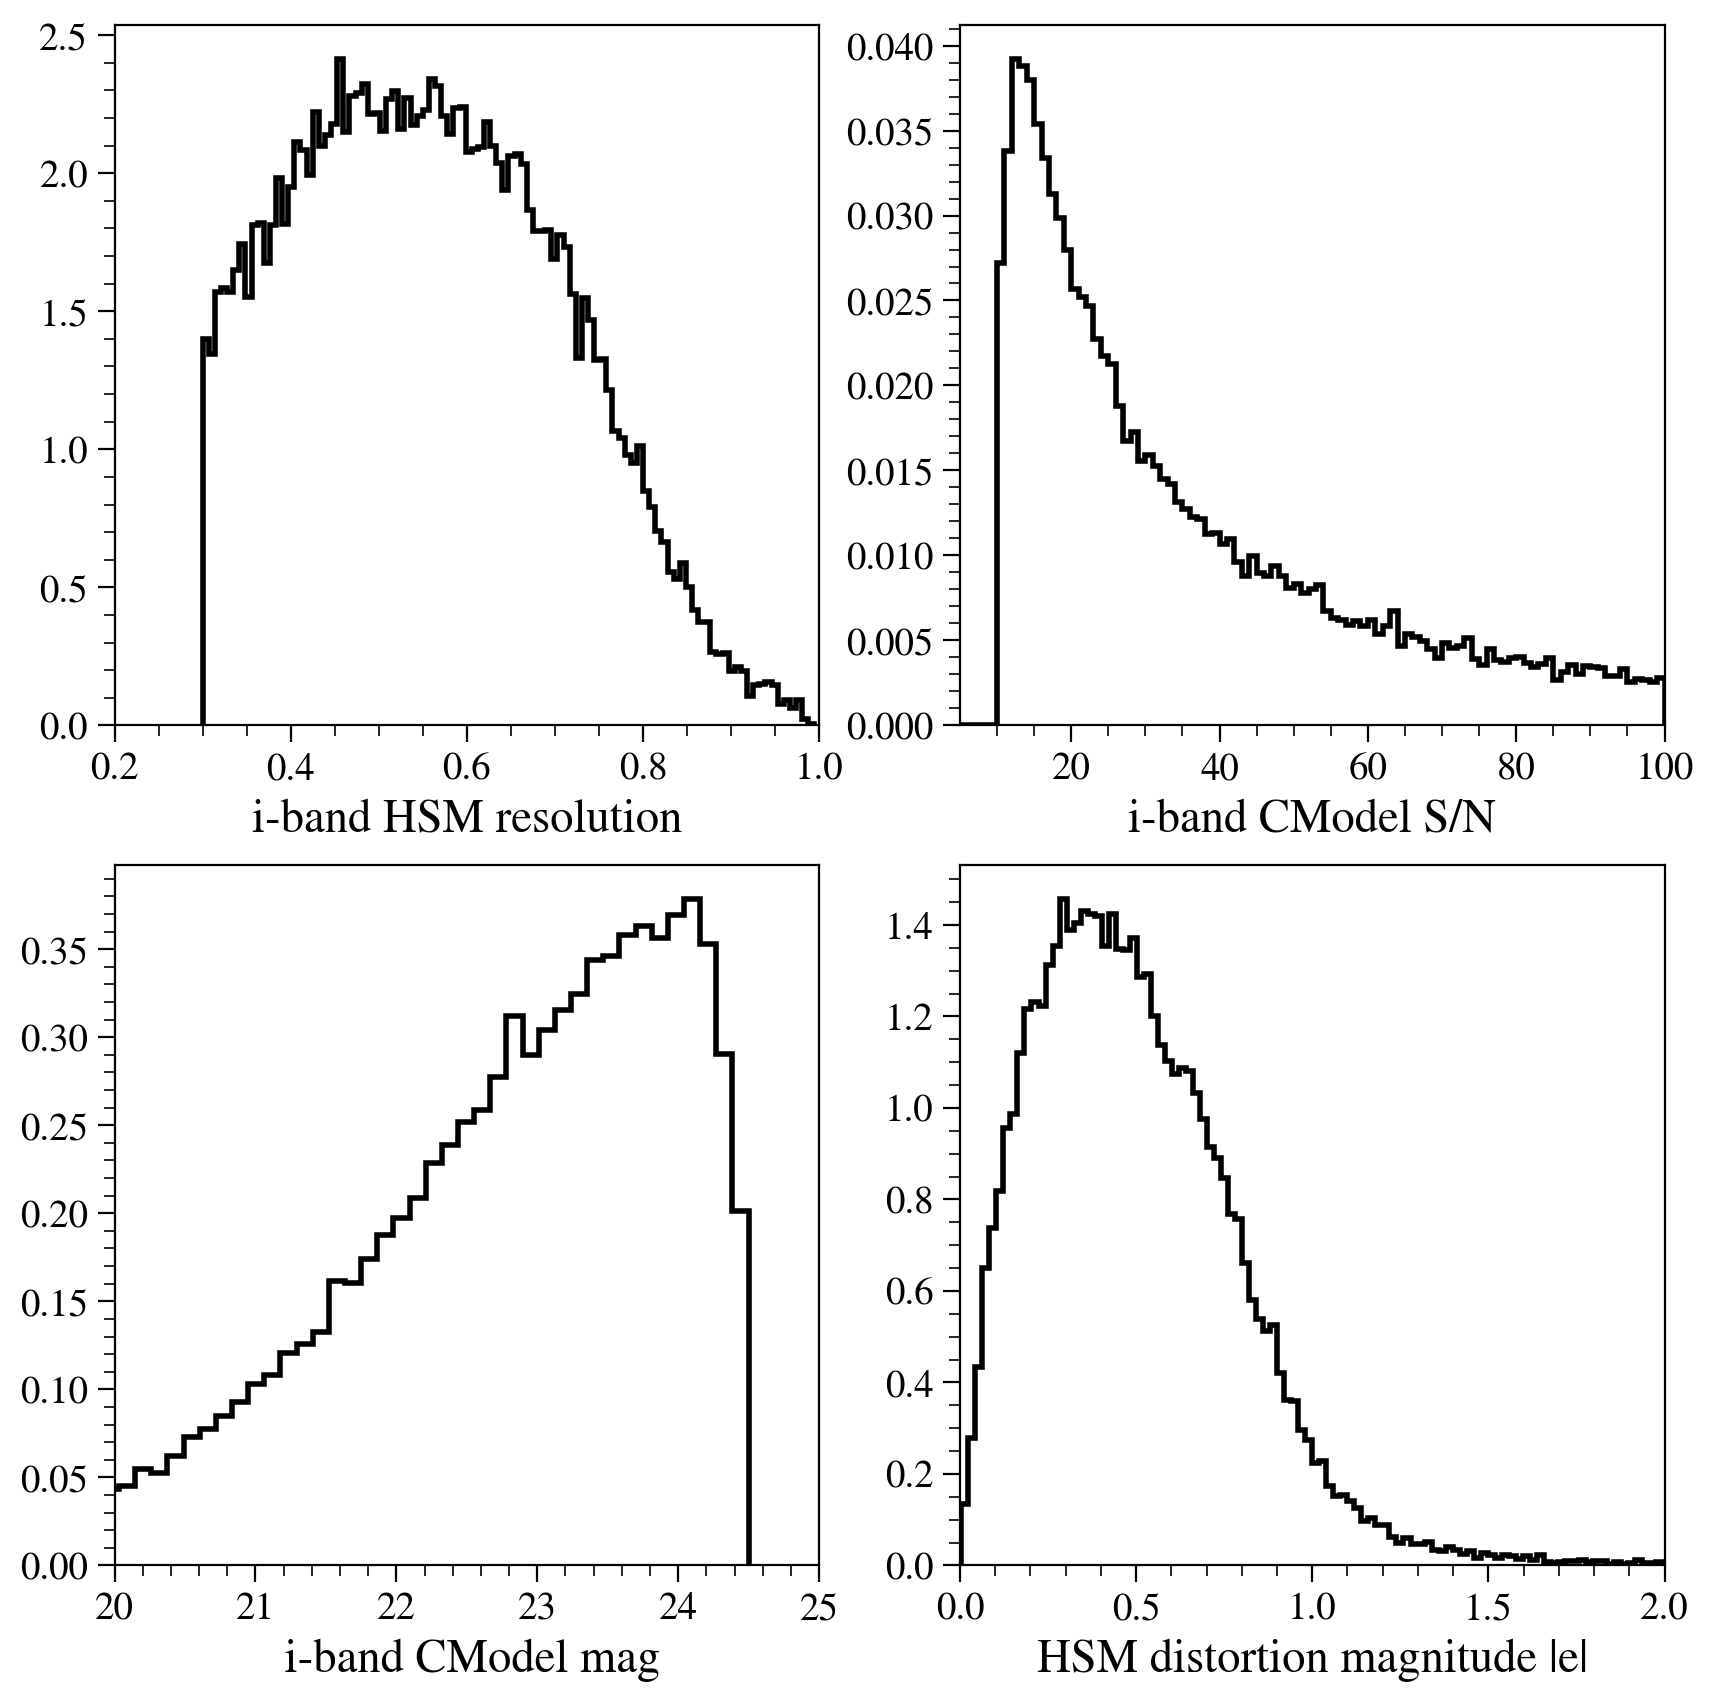

In [7]:
fig = plt.figure(figsize=(10, 10))
hist_kwds = dict(bins=100, histtype='step', normed=True, linewidth=2.0, color="black")
p1 = fig.add_subplot(2, 2, 1)
plt.hist(data['ext_shapeHSM_HsmShapeRegauss_resolution'][mask], **hist_kwds);
plt.xlabel('{}-band HSM resolution'.format(filter_))
plt.xlim([0.2,1])
p2 = fig.add_subplot(2, 2, 2)
plt.hist(data[filter_ + '_modelfit_CModel_SNR'][mask], range=(0, 100), **hist_kwds);
plt.xlabel('{}-band CModel S/N'.format(filter_))
plt.xlim([5,100])
p3 = fig.add_subplot(2, 2, 3)
plt.hist(data[filter_ + '_mag_CModel'][mask], **hist_kwds);
plt.xlabel(' {}-band CModel mag'.format(filter_))
plt.xlim([20,25])
p4 = fig.add_subplot(2, 2, 4)
plt.hist(data['ext_shapeHSM_HsmShapeRegauss_abs_e'][mask], **hist_kwds);
plt.xlabel('HSM distortion magnitude |e|')
plt.xlim([0,2]);

Here's the published figure, for comparison: 

![](https://user-images.githubusercontent.com/710903/42742471-a196979e-886f-11e8-81f6-a89e425f9be3.png)